In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [71]:
train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('used_car_testB_20200421.csv', sep=' ')

### 常见的特征工程包括
摘抄自:
https://github.com/datawhalechina/team-learning-data-mining/blob/master/SecondHandCarPriceForecast/Task3%20%E7%89%B9%E5%BE%81%E5%B7%A5%E7%A8%8B.md
1. 异常处理：
   - 通过箱线图（或 3-Sigma）分析删除异常值；
   - BOX-COX 转换（处理有偏分布）；
   - 长尾截断；
2. 特征归一化/标准化：
   - 标准化（转换为标准正态分布）；
   - 归一化（抓换到 [0,1] 区间）；
   - 针对幂律分布，可以采用公式： $log(\frac{1+x}{1+median})$
3. 数据分桶：
   - 等频分桶；
   - 等距分桶；
   - Best-KS 分桶（类似利用基尼指数进行二分类）；
   - 卡方分桶；
4. 缺失值处理：
   - 不处理（针对类似 XGBoost 等树模型）；
   - 删除（缺失数据太多）；
   - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
   - 分箱，缺失值一个箱；
5. 特征构造：
   - 构造统计量特征，报告计数、求和、比例、标准差等；
   - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
   - 地理信息，包括分箱，分布编码等方法；
   - 非线性变换，包括 log/ 平方/ 根号等；
   - 特征组合，特征交叉；
   - 仁者见仁，智者见智。
6. 特征筛选
   - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
   - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
   - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
   - PCA/ LDA/ ICA；
   - 特征选择也是一种降维。

### 1.删除异常值

In [4]:
# 异常值处理的代码
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

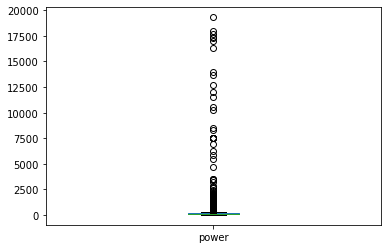

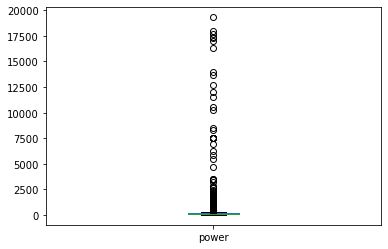

In [31]:
# 上次在做EDA时发现power存在很多很大的异常值,power中存在最多的数值是0，但是不知道0是什么含义
# 抛开0外的数据还是存在较多异常值，所以如果数量不多的话打算把这些异常值去掉
train_data[train_data['power'] != 0]['power'].plot(kind = 'box')
plt.show()
train_data['power'].plot(kind = 'box')
plt.show()

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149032,149995,163978,20000607,121.0,10,4.0,0.0,1.0,163,15.0,...,0.280264,0.000310,0.048441,0.071158,0.019174,1.988114,-2.983973,0.589167,-1.304370,-0.302592
149033,149996,184535,20091102,116.0,11,0.0,0.0,0.0,125,10.0,...,0.253217,0.000777,0.084079,0.099681,0.079371,1.839166,-2.774615,2.553994,0.924196,-0.272160
149034,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,...,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149035,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,...,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014


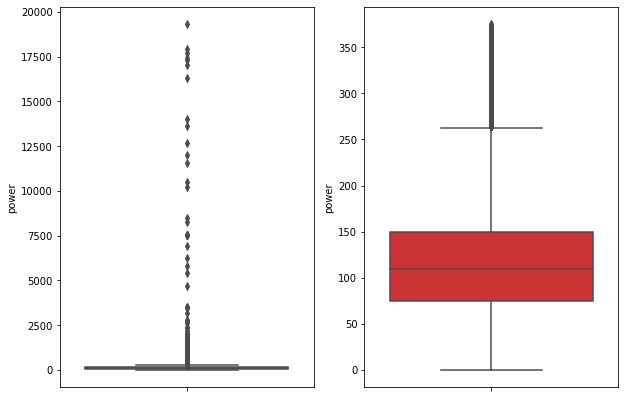

In [32]:
outliers_proc(train_data, 'power', scale=3)

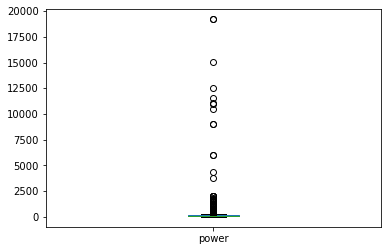

In [33]:
# 但是通过验证集的箱型图来看，也是存在这些异常值，所以这些异常值可能不是真正的异常值，所以不考虑删除
# 后续可以试试用3σ原则边界值来截断并填充异常值或者用分桶或者用取log后进行归一化
test_data['power'].plot(kind = 'box')
plt.show()

### 2.特征构造

In [72]:
# 训练集和测试集放在一起，方便构造特征
train_data['train']=1
test_data['train']=0
data = pd.concat([train_data, test_data], ignore_index=True, sort=False)

In [73]:
# 构造特征 - 时间特征-- 相对时间
# 汽车的使用时间：data['creatDate'] - data['regDate']

# 时间数据中，20000008这类数据不知道是指八月还是一月八号，我倾向于八月，先暂时认为是八月，后续试试不处理的效果做对比
for i in range (len(data['creatDate'])):
    item = str(data['creatDate'].loc[i])
    if item[4:6] == '00':
        item = item[:4] + item[-2:] + '15'
        data['creatDate'].loc[i] = item

for i in range (len(data['regDate'])):
    item = str(data['regDate'].loc[i])
    if item[4:6] == '00':
        item = item[:4] + item[-2:] + '15'
        data['regDate'].loc[i] = item

data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [74]:
# 构造特征 - 统计特征
# 按照参考的链接，这里也是计算某品牌的销售统计量，后续可以计算其他特征的统计量
# 注意这里要用训练集的统计量，因为测试集的统计量是未知的哦
train_gb = train_data.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

该类别种类数 99662


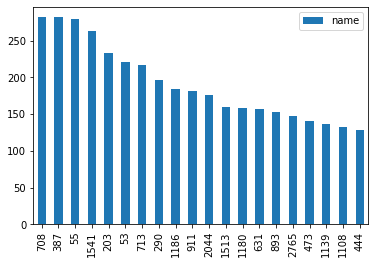

KeyboardInterrupt: 

In [75]:
# 处理name特征
name = pd.DataFrame(train_data['name'].value_counts())
print('该类别种类数',len(set(train_data['name'])))
name.sort_values(by='name',ascending=False,inplace=True)
name.head(20).plot.bar()
plt.show()

'''可以看到类别有很多类，直接输入到模型不太ok，因为如果不归一化的话，有的类别代表的数值
太大了，会引起权重的不对等，归一化后，类别的归一化好像不能带来什么信息，所以可以考虑用name的
频率来构建特征，主观上可能会觉得name出现的频率越高的就是越常见的车型，价格可能会相对低一点'''

train_gb = train_data.groupby("name")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['name_amount'] = len(kind_data)
    all_info[kind] = info
name_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "name"})
data = data.merge(brand_fe, how='left', on='name')

'''
报错了，可能是测试集出现了训练集所没有的name，不过快到了打卡时间了，先不管了=='''

In [76]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [77]:
# 按照前面说的，给power分个桶
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [78]:
# 利用好了，就可以删掉原始数据了
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [ ]:
# 树模型不需要做归一化，所以在这里保存一下
data.to_csv('data_for_tree.csv', index=0)

### 总结：还有很多特征构造得尝试，例如匿名特征间的组合

### 2.特征标准化

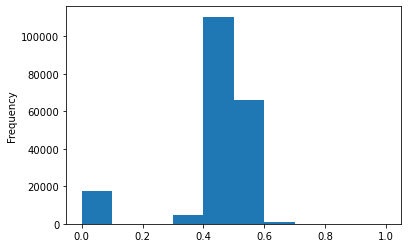

In [79]:
### 如果模型不是树模型，就需要对数据进行标准化
# 由前面可知power为长尾分布且存在异常值，此处对power进行取log后归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

In [80]:
# 从EDA可以看出km不存在长尾分布的现象，所以跟刚才构建的统计量特征一起直接做归一化
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['kilometer'] = max_min(data['kilometer'])

data['brand_amount'] = max_min(data['brand_amount'])
data['brand_price_average'] = max_min(data['brand_price_average'])
data['brand_price_max'] = max_min(data['brand_price_max'])
data['brand_price_median'] = max_min(data['brand_price_median'])
data['brand_price_min'] = max_min(data['brand_price_min'])
data['brand_price_std'] = max_min(data['brand_price_std'])
data['brand_price_sum'] = max_min(data['brand_price_sum'])

In [81]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [ ]:
# 这份数据可以给 非树模型例如LR 用
data.to_csv('data_for_lr.csv', index=0)

### 特征选择

0.5773425426332196
-0.4097783640876424
0.05438301230221679
0.38875954584355615
0.2587402623951201
0.39159165603497703


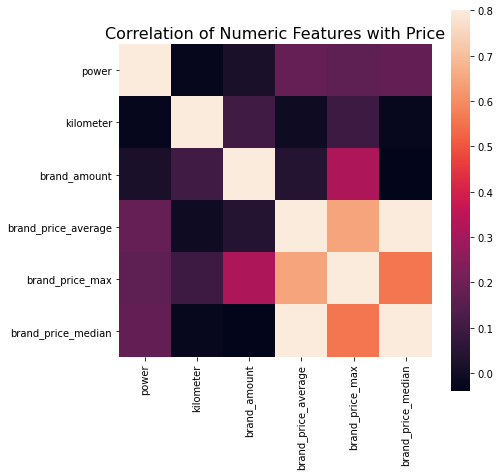

In [82]:
# 1.利用相关性来过滤
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

# 画图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [ ]:
# 2.利用树模型来输出特征重要性